## Single-Cell RNA Sequencing Analysis

Single-cell RNA sequencing (scRNA-seq) has transformed our understanding of the cellular complexity within tissues. In this notebook, we will explore a dataset from the study titled: *Cryopreservation of human cancers conserves tumour heterogeneity for single-cell multi-omics analysis*. This study can be accessed [here](https://singlecell.broadinstitute.org/single_cell/study/SCP1415/cryopreservation-of-human-cancers-conserves-tumour-heterogeneity-for-single-cell-multi-omics-analysis#study-download).

The dataset contains gene expression data for 117,573 cells. Our aim is to process, analyze, and visualize this data to discern patterns of cellular heterogeneity. Specifically, we're interested in understanding how different cryopreservation methods affect the molecular profiles of individual cells. We have downloaded the following files for our analysis:

- Raw gene expression matrix
- Cell barcodes
- Gene names
- Metadata with additional information about each cell

Let's start by loading our data into an appropriate format for analysis.


In [16]:
# Importing necessary libraries
import scanpy as sc
import pandas as pd

# Reading the matrix file that contains the raw gene expression data
adata = sc.read_mtx("Wu_etal_2021_allcells_raw_counts.mtx").T

# Assigning gene names and cell barcodes to our data structure
adata.var_names = pd.read_csv("Wu_etal_2021_allcells_genes.tsv", header=None)[0].values
adata.obs_names = pd.read_csv("Wu_etal_2021_allcells_barcodes.tsv", header=None)[0].values

# Merging the metadata to our data structure
metadata = pd.read_csv("Wu_etal_2021_metadata.txt", sep="\t", index_col=0)
adata.obs = pd.concat([adata.obs, metadata], axis=1, join="inner")


C:\Users\sarab\AppData\Local\Temp\ipykernel_34028\3081285787.py:13: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("Wu_etal_2021_metadata.txt", sep="\t", index_col=0)


In [17]:
# Filtering out cells based on gene expression criteria
sc.pp.filter_cells(adata, min_genes=200)
# Filtering out genes based on expression in minimum number of cells
sc.pp.filter_genes(adata, min_cells=3)

# Normalizing the data for sequencing depth per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transforming the data
sc.pp.log1p(adata)

# Identifying highly-variable genes 
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Subsetting the data to only include these highly-variable genes
adata = adata[:, adata.var['highly_variable']]


AnnData object with n_obs × n_vars = 117573 × 2111
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'Condition', 'CellType', 'ClusterID', 'n_genes', 'louvain'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


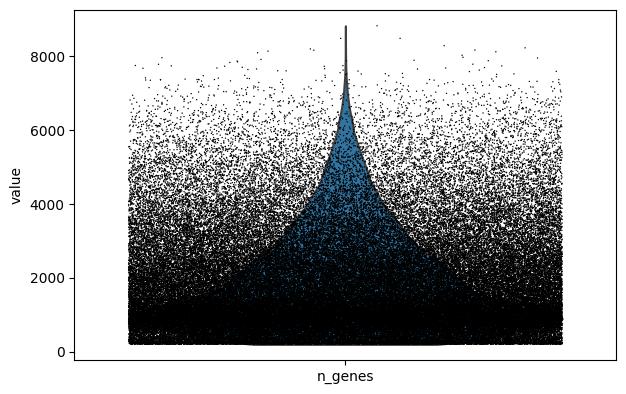

                         biosample_id donor_id         species  \
CID4471_AAACCTGAGATCCCAT        BC-P1  CID4471  NCBITaxon_9606   
CID4471_AAACCTGCAGCTTCGG        BC-P1  CID4471  NCBITaxon_9606   
CID4471_AAACCTGGTGGAAAGA        BC-P1  CID4471  NCBITaxon_9606   
CID4471_AAACCTGGTTCACCTC        BC-P1  CID4471  NCBITaxon_9606   
CID4471_AAACCTGTCACATGCA        BC-P1  CID4471  NCBITaxon_9606   

                         species__ontology_label        disease  \
CID4471_AAACCTGAGATCCCAT            Homo sapiens  MONDO_0007254   
CID4471_AAACCTGCAGCTTCGG            Homo sapiens  MONDO_0007254   
CID4471_AAACCTGGTGGAAAGA            Homo sapiens  MONDO_0007254   
CID4471_AAACCTGGTTCACCTC            Homo sapiens  MONDO_0007254   
CID4471_AAACCTGTCACATGCA            Homo sapiens  MONDO_0007254   

                         disease__ontology_label           organ  \
CID4471_AAACCTGAGATCCCAT           breast cancer  UBERON_0000310   
CID4471_AAACCTGCAGCTTCGG           breast cancer  UBERON_0000310

In [27]:
# Display basic information about the dataset
print(adata)

# Plot the distribution of number of genes expressed across cells
sc.pl.violin(adata, ['n_genes'], jitter=0.4)

# Check the metadata associated with cells
print(adata.obs.head())

From the displayed information and plot:
The violin plot showcases the distribution of the number of genes expressed across cells. Most cells have expressions for around 2000-4000 genes, but there's a noticeable spread. It's common to have some cells with very low or very high numbers of expressed genes due to various biological or technical factors.
The metadata (adata.obs) indicates each cell's metadata, such as its biosample ID, donor ID, species, disease status, organ from which it was derived, and other details. This can be very useful for subsetting or grouping cells for downstream analysis based on these attributes.


## Dimensionality Reduction and Clustering

After preprocessing, we're left with a matrix that has thousands of genes. However, not all of these dimensions are informative for understanding the underlying structure or the relationships between cells. Dimensionality reduction techniques help condense this information into fewer dimensions, making it easier to visualize and interpret.

Our steps in this phase include:
1. **Scaling**: Ensuring each gene has a mean of zero and unit variance. This step prepares the data for PCA and ensures that all genes are on an equal footing.
2. **PCA (Principal Component Analysis)**: A technique to reduce the dimensions of the dataset while retaining as much variance as possible.
3. **Neighborhood Graph Construction**: Based on the PCA, we'll compute how cells relate to their neighbors. This is essential for both visualization and clustering.
4. **UMAP (Uniform Manifold Approximation and Projection)**: A popular method to visualize high-dimensional data in 2D or 3D. UMAP captures both local and global structures in the data.
5. **Louvain Clustering**: This will group cells based on their similarities in gene expression, aiding in the identification of potential cell types or states.

Let's dive into these steps.


In [19]:
# Scaling the data such that each gene has mean 0 and variance 1
sc.pp.scale(adata, max_value=10)

# Performing PCA to reduce dimensions
sc.tl.pca(adata, svd_solver='arpack')

# Constructing the neighborhood graph based on PCA results
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Computing UMAP for visualization
sc.tl.umap(adata)

# Clustering cells using the Louvain method based on the neighborhood graph
sc.tl.louvain(adata)


## Visualization and Cluster Analysis

After the dimensionality reduction and clustering steps, our next task is to visualize the results in an intuitive manner. Visualization is essential as it can provide immediate insights into the structure of the data, reveal patterns, and help interpret the results of clustering.

UMAP (Uniform Manifold Approximation and Projection) is a widely-used technique to visualize high-dimensional data in a 2D or 3D space. By coloring each cell based on its cluster (from the Louvain algorithm), we can understand how cells are grouped based on their gene expression patterns. This often correlates with cell types, cell states, or other biologically meaningful categorizations.

In this section, we'll:
1. **Visualize Cells Using UMAP**: Each dot in the UMAP plot corresponds to a cell, and the spatial arrangements of the dots reflect the similarities in their gene expression profiles.
2. **Interpret Clusters**: By coloring cells based on their assigned Louvain clusters, we can get a sense of the cellular heterogeneity in the sample.

Let's generate the UMAP plot.


c:\Users\sarab\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


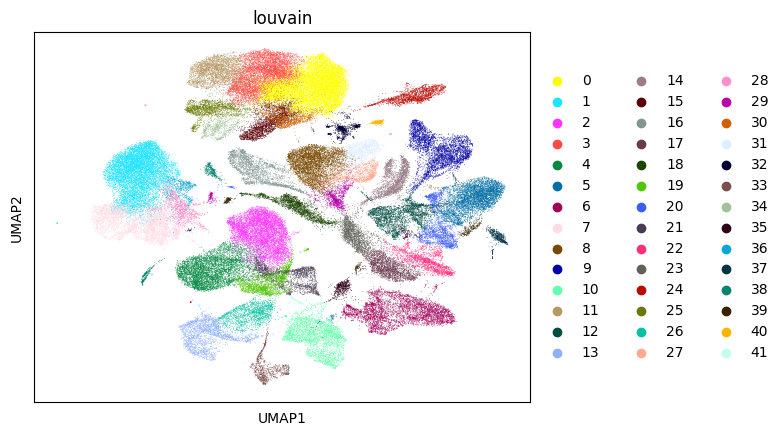

In [20]:
sc.pl.umap(adata, color=['louvain'])


## UMAP Visualization Interpretation

The UMAP plot displayed above represents the 2D projection of our high-dimensional single-cell RNA sequencing data. Each point on the plot corresponds to a single cell, and the spatial proximity of these points indicates their similarity in terms of gene expression patterns.

From the plot, we can observe several distinct clusters, as indicated by the coloring based on the Louvain algorithm. Each color corresponds to a specific cluster, and the numbers in the legend on the right provide cluster IDs.

### Key Observations:

1. **Cluster Distribution**: There are a significant number of distinct clusters, suggesting a high degree of cellular heterogeneity in the sample.
2. **Cluster Sizes**: Some clusters are much larger than others, indicating that certain cell types or states might be more prevalent.
3. **Spatial Relationships**: Some clusters are closely packed together, suggesting subtle differences or transitional states between them, while others are more isolated, indicating more distinct cell populations.

This visualization provides a foundation for deeper analysis, where we can investigate the gene expression patterns that define each cluster and potentially identify the cell types or states they represent.

With the clusters defined, we have several analytical avenues to explore:
- **Differential Expression Analysis**: Identify genes that are differentially expressed between clusters.
- **Cell Type Annotation**: By comparing the gene expression signatures of each cluster with known cell type markers, we can potentially annotate our clusters.
- **Pseudotime Analysis**: For datasets with developmental trajectories or differentiation processes, we can order cells in pseudotime to study the dynamic processes.
- **Integration with Other Data**: If other modalities of data are available (e.g., protein expression, ATAC-seq), we can integrate them to gain more comprehensive insights.




-----------------------------------------------------------------------------------------------------------------------------------------------

# Differential Expression Analysis

To identify genes that are differentially expressed between different groups of cells, it's essential to perform differential expression analysis. This method will highlight the genes that show significant changes in expression levels between the specified groups of cells. The following code will help in achieving this. It uses the `rank_genes_groups` function from Scanpy to rank genes for their differential expression between different clusters of cells.


c:\Users\sarab\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\sarab\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


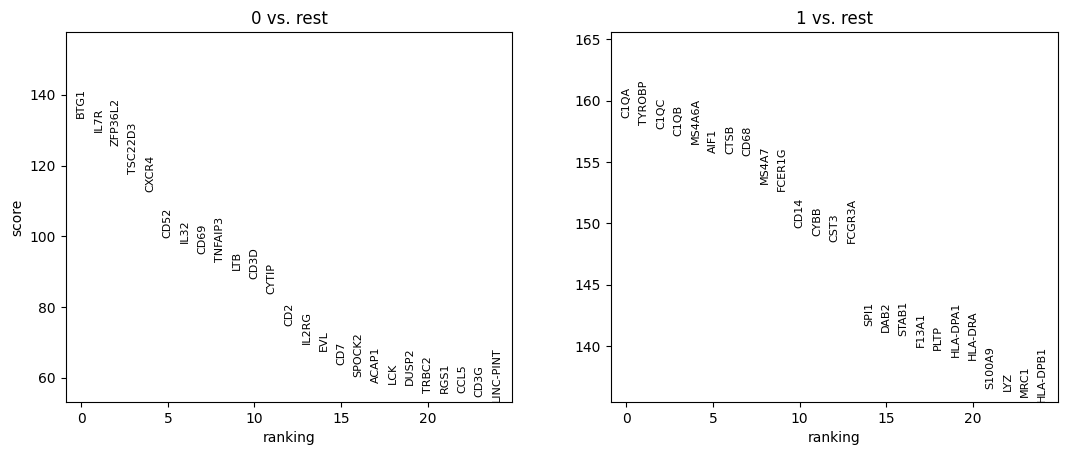

In [28]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0', '1'], method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


# Differential Expression Analysis Results

The differential expression analysis results show the top-ranked genes that are differentially expressed between two groups, specifically '0' versus the rest and '1' versus the rest.

## Observations:

1. **Differential Expression Plot**:
   - The plots display the top genes that are differentially expressed for the groups '0' and '1', respectively.
   - The y-axis represents the score, which reflects the significance of differential expression.
   - The x-axis depicts the ranking of the genes, with the genes on the far left being the most significantly differentially expressed.

2. **Key Genes**: 
   - For the group '0 vs. rest', some of the prominently featured genes include BTG1, IL7R, ZFP36L2, and TSC22D3.
   - For the group '1 vs. rest', the top genes are C1QA, CTROCP, and C1QB.

Further investigations can be conducted on these genes to understand their biological roles and their significance in the context of the study.
